In [90]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [13]:
g_datafolder = '/development/data'
g_customer_dataset = '{}/olist_customers_dataset.csv'.format(g_datafolder)
g_orders_dataset = '{}/olist_orders_dataset.csv'.format(g_datafolder)
g_payments_dataset = '{}/olist_order_payments_dataset.csv'.format(g_datafolder)
g_orderitems_dataset = '{}/olist_order_items_dataset.csv'.format(g_datafolder)


In [82]:
def load_dataset(datafile, parse_dates=None):
    df = pd.read_csv(datafile, delimiter=',', parse_dates=parse_dates)
    return df

def add_datediffcolumn(df, col_dt1, col_dt2, colname):
    df[colname] = np.round((df[col_dt1] - cust_ord_df[col_dt2]) / np.timedelta64(1, 'M'), 0)
    df[colname][df[colname].isna()] = 0.0
    return df

In [91]:
customer_df = load_dataset(g_customer_dataset)
parse_dates = ['order_purchase_timestamp']
orders_df = load_dataset(g_orders_dataset, parse_dates=parse_dates)
payments_df = load_dataset(g_payments_dataset)
orderitems_df = load_dataset(g_orderitems_dataset)
cust_ord_df = orders_df.set_index('customer_id').join(customer_df.set_index('customer_id'), how="inner").reset_index()
cust_ord_df = cust_ord_df.set_index('order_id').join(orderitems_df.set_index('order_id'), how="inner").reset_index()
cust_ord_df['total_value'] = np.round(cust_ord_df['price'] + cust_ord_df['freight_value'], 0)
cust_ord_df['firstorder_purchase_timestamp'] = cust_ord_df['order_purchase_timestamp']
cust_ord_df['lastorder_purchase_timestamp'] = cust_ord_df['order_purchase_timestamp']
groupby_cols = ['customer_unique_id', 'order_purchase_timestamp']
all_cols = groupby_cols + ['order_id', 'product_id', 'total_value', 'firstorder_purchase_timestamp', 'lastorder_purchase_timestamp']
cust_ord_df = cust_ord_df[all_cols].groupby(groupby_cols).agg({'order_id':'nunique' \
                                                               , 'product_id':'nunique' \
                                                               , 'firstorder_purchase_timestamp':'min' \
                                                               , 'lastorder_purchase_timestamp':'max' \
                                                               , 'total_value':'sum'}).reset_index()
cust_ord_df['previous_order_purchase_timestamp'] = cust_ord_df.sort_values(['customer_unique_id', 'order_purchase_timestamp']).groupby(['customer_unique_id'])['order_purchase_timestamp'].shift(1)
#cust_ord_df['interpurchase_interval'] = (cust_ord_df['order_purchase_timestamp'] - cust_ord_df['previous_order_purchase_timestamp']).dt.days
cust_ord_df = add_datediffcolumn(cust_ord_df, 'order_purchase_timestamp', 'previous_order_purchase_timestamp', 'interpurchase_interval')
cust_ord_df['order_rank'] = cust_ord_df.groupby('customer_unique_id')['order_purchase_timestamp'].rank()
cust_ord_df = add_datediffcolumn(cust_ord_df, 'order_purchase_timestamp', 'firstorder_purchase_timestamp', 'age')
cust_ord_df['max_date'] = datetime(2018, 12, 31)
cust_ord_df = add_datediffcolumn(cust_ord_df, 'max_date', 'lastorder_purchase_timestamp', 'interval_sincelastpurchase')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [99]:
cust_ord_df[cust_ord_df.order_rank > 1.0].head()

,customer_unique_id,order_purchase_timestamp,order_id,product_id,firstorder_purchase_timestamp,lastorder_purchase_timestamp,total_value,previous_order_purchase_timestamp,interpurchase_interval,order_rank,age,max_date,interval_sincelastpurchase
107,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,1,1,2018-01-14 07:36:54,2018-01-14 07:36:54,103.0,2017-07-27 14:13:03,6.0,2.0,0.0,2018-12-31,12.0
125,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,1,1,2018-05-26 19:42:48,2018-05-26 19:42:48,50.0,2017-09-01 12:11:23,9.0,2.0,0.0,2018-12-31,7.0
146,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41,1,1,2018-03-22 18:09:41,2018-03-22 18:09:41,96.0,2018-02-19 17:11:34,1.0,2.0,0.0,2018-12-31,9.0
250,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,1,1,2018-06-03 10:12:57,2018-06-03 10:12:57,27.0,2018-05-23 20:14:21,0.0,2.0,0.0,2018-12-31,7.0
314,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,1,1,2017-03-21 19:25:23,2017-03-21 19:25:23,82.0,2017-03-21 19:25:22,0.0,2.0,0.0,2018-12-31,21.0


In [100]:
cust_ord_df[cust_ord_df.customer_unique_id == '004288347e5e88a27ded2bb23747066c'].head()


,customer_unique_id,order_purchase_timestamp,order_id,product_id,firstorder_purchase_timestamp,lastorder_purchase_timestamp,total_value,previous_order_purchase_timestamp,interpurchase_interval,order_rank,age,max_date,interval_sincelastpurchase
106,004288347e5e88a27ded2bb23747066c,2017-07-27 14:13:03,1,1,2017-07-27 14:13:03,2017-07-27 14:13:03,251.0,NaT,0.0,1.0,0.0,2018-12-31,17.0
107,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,1,1,2018-01-14 07:36:54,2018-01-14 07:36:54,103.0,2017-07-27 14:13:03,6.0,2.0,0.0,2018-12-31,12.0


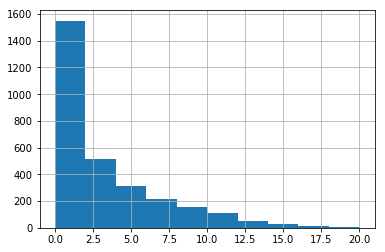

In [84]:
#temp_df = cust_ord_df[cust_ord_df.order_rank > 1.0][['interpurchase_interval', 'customer_unique_id']].groupby('interpurchase_interval').agg({'customer_unique_id':'nunique'}).reset_index()
#ax = temp_df.plot.bar(x='interpurchase_interval', y='customer_unique_id', rot=0)
ax = cust_ord_df[cust_ord_df.order_rank > 1.0].interpurchase_interval.hist()


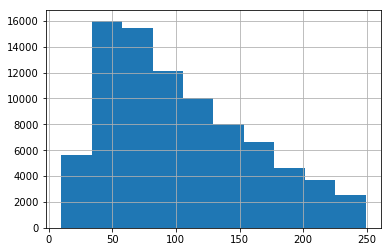

In [85]:
ax = cust_ord_df[cust_ord_df.total_value < 250].total_value.hist()


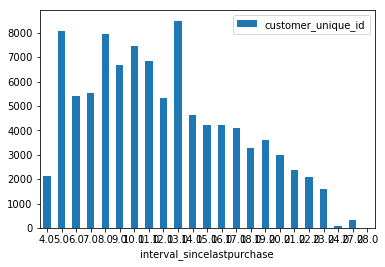

In [97]:
cust_ord_df.interval_sincelastpurchase.describe()
temp_df = cust_ord_df[['interval_sincelastpurchase', 'customer_unique_id']].groupby('interval_sincelastpurchase').agg({'customer_unique_id':'nunique'}).reset_index()
ax = temp_df.plot.bar(x='interval_sincelastpurchase', y='customer_unique_id', rot=0)


In [96]:
cust_ord_df.interpurchase_interval.describe()

count    98381.000000
mean         0.085098
std          0.793688
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: interpurchase_interval, dtype: float64